🐑Libraries

In [1]:
!nvidia-smi

Sun Mar 12 21:13:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    50W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install timm~=0.4.12
!pip install scikit-learn~=1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 KB 8.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 51.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.1
    Uninstalling scikit-learn-1.2.1:
      Successfully uninstalled scikit-learn-1.2.1


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/MonkeyPox

/content/drive/MyDrive/MonkeyPox


In [5]:
!ls

 cnn+lstm.ipynb   ens_csp.json	'ens_repvgg_b0 .json'  'Mssodel Evals.ipynb'
 CNNs		  ens_csp.pth	'ens_repvgg_b0 .pth'    __pycache__
 dataset	  ens_nas.json	 main.ipynb	        result_analysis.ipynb
 dataset.zip	  ens_nas.pth	'Model Evals.ipynb'     train.py


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
import numpy as np

In [7]:
import copy
import json
import os
import timm
from sklearn.metrics import accuracy_score, cohen_kappa_score, \
    matthews_corrcoef, f1_score, recall_score, precision_score
from torch.utils.data import Dataset
from torchvision import datasets, transforms

In [29]:
from sklearn.metrics import cohen_kappa_score,classification_report,confusion_matrix,roc_curve,roc_auc_score,matthews_corrcoef

In [9]:
_model_name="ens_pro"
_num_epochs=100
_batch_size=8
_device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
_loss_fn=nn.CrossEntropyLoss()

In [10]:
data_dir = './dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

pretrained_size = 224

pretrained_means = [0.485,0.456,0.406]

pretrained_stds= [0.229,0.224,0.225]

batch_size=8


data_transforms = {
    
    'train': transforms.Compose([
        transforms.Resize((pretrained_size,pretrained_size)),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomRotation(15),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize((pretrained_size,pretrained_size)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
        
    ])
,
    'val': transforms.Compose([
        transforms.Resize((pretrained_size,pretrained_size)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
        
    ])}


print("Initializing Datasets and Dataloaders...\n")
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test','val']}
# Create training and validation dataloaders
_dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True) for x in ['train', 'test','val']}
# Dataset size calculations
dataset_sizes ={x:len(image_datasets[x]) for x in ['train','test','val']}

Initializing Datasets and Dataloaders...



In [11]:
def set_history():
        history = {'train': {
            'accuracy': [],
            'loss': [],
            'precision': [],
            'recall': [],
            'f1-score': [],
            'cohen_kappa_score': [],
            'matthews_corrcoef': [],
        }, 'val': {
            'accuracy': [],
            'loss': [],
            'precision': [],
            'recall': [],
            'f1-score': [],
            'cohen_kappa_score': [],
            'matthews_corrcoef': [],
        }, 'model_name': _model_name, 'num_epochs': _num_epochs, 'batch_size': _batch_size}
        return history

In [12]:
_metrics = ['accuracy', 'loss',
                 'precision',
                 'recall',
                 'f1-score',
                 'roc_auc_score',
                 'cohen_kappa_score',
                 'matthews_corrcoef',
                 'confusion_matrix']

In [13]:
def writeJson( history):
    log_file = _model_name + ".json"
    with open(log_file, "w") as outfile:
        json.dump(history, outfile)

In [14]:
def train_epoch():

    train_loss, train_correct = 0.0, 0
    _model.train()

    __labels = torch.tensor([0]).to(_device)
    __predictions = torch.tensor([0]).to(_device)

    for images, labels in _dataloaders["train"]:
        images, labels = images.to(_device), labels.to(_device)
        _optimizer.zero_grad()
        output = _model(images)
        loss = _loss_fn(output, labels)
        loss.backward()
        _optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()
        __labels = torch.cat((__labels, labels), 0)
        __predictions = torch.cat((__predictions, predictions), 0)

    return train_loss, __labels[1::], __predictions[1::], scores

def valid_epoch(dataloader):
    valid_loss, val_correct = 0.0, 0
    _model.eval()
    __labels = torch.tensor([0]).to(_device)
    __predictions = torch.tensor([0]).to(_device)

    for images, labels in dataloader:
        images, labels = images.to(_device), labels.to(_device)
        output = _model(images)
        loss = _loss_fn(output, labels)
        valid_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        val_correct += (predictions == labels).sum().item()
        __labels = torch.cat((__labels, labels), 0)
        __predictions = torch.cat((__predictions, predictions), 0)

    return valid_loss, __labels[1::], __predictions[1::], scores

In [15]:
def train_model():
    
    history = set_history()
    best_acc = 0.0
    best_model_wts = None
    best_model_wts = None
    _predictions={}
    _labels={}
    _predictions["train"]=[]
    _predictions["val"]=[]
    _labels["train"]=[]
    _labels["val"]=[]
    for epoch in range(_num_epochs):
        train_loss, _labels["train"], _predictions["train"], train_scores = train_epoch()
        test_loss, _labels["val"],  _predictions["val"], test_scores = valid_epoch(_dataloaders["val"])
        for phase in ['train', 'val']:
            for metric in _metrics:
                if metric == "accuracy":
                    history[phase][metric].append(accuracy_score(_labels[phase].cpu(), _predictions[phase].cpu()))
                elif metric == "loss":
                    if phase == 'train':
                        history[phase][metric].append(train_loss / len(_dataloaders[phase]))
                    else:
                        history[phase][metric].append(test_loss / len(_dataloaders[phase]))
                elif metric == "precision":
                    history[phase][metric].append(
                        precision_score(_labels[phase].cpu(), _predictions[phase].cpu(), average='weighted'))

                elif metric == "recall":
                    history[phase][metric].append(
                        recall_score(_labels[phase].cpu(), _predictions[phase].cpu(), average='weighted'))

                elif metric == "f1-score":
                    history[phase][metric].append(
                        f1_score(_labels[phase].cpu(), _predictions[phase].cpu(), average='weighted'))

                elif metric == "cohen_kappa_score":
                    history[phase][metric].append(cohen_kappa_score(_labels[phase].cpu(), _predictions[phase].cpu()))

                elif metric == "matthews_corrcoef":
                    history[phase][metric].append(matthews_corrcoef(_labels[phase].cpu(), _predictions[phase].cpu()))
        # deep copy the model
        if history["val"]["accuracy"][epoch] > best_acc:
            print('Best Val Acc. has been updated: {:4f}'.format(history["val"]["accuracy"][epoch]))
            best_acc = history["val"]["accuracy"][epoch]
            best_model_wts = copy.deepcopy(_model.state_dict())
        print('Epoch {:.1f} has been completed with {:.3f} validation accuracy'.format(epoch,
                                                                                        history["val"]["accuracy"][
                                                                                            epoch]))
    print('Best Val Acc.: {:4f}'.format(best_acc))
    _model.load_state_dict(best_model_wts)
    model_path = "./" + _model_name + ".pth"
    torch.save(best_model_wts, model_path)
    writeJson(history)

In [16]:
cnn_encoder_0=timm.create_model("repvgg_b0", pretrained=False)
cnn_encoder_0.head.fc.out_features = 4
__model_result_path="./CNNs/"+"repvgg_b0"+".pth"
cnn_encoder_0.load_state_dict(torch.load(__model_result_path))
cnn_encoder_0.head.fc =nn.Identity()

In [17]:
cnn_encoder_1=timm.create_model("mnasnet_100", pretrained=False)
cnn_encoder_1.classifier.out_features = 4
__model_result_path="./CNNs/"+"mnasnet_100"+".pth"
cnn_encoder_1.load_state_dict(torch.load(__model_result_path))
cnn_encoder_1.classifier =nn.Identity()

In [18]:
# Define the LSTM encoder
class LSTMEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        x = h[-1, :, :]
        return x

# Define the ensemble model
class Ensemble(nn.Module):
    def __init__(self, cnn_encoder_0,cnn_encoder_1, lstm_encoder, num_classes):
        super(Ensemble, self).__init__()
        self.cnn_encoder_0 = cnn_encoder_0
        self.cnn_encoder_1 = cnn_encoder_1
        self.lstm_encoder = lstm_encoder

        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.dropout_fc = nn.Dropout(0.1)
        self.dropout_fc1 = nn.Dropout(0.1)
        self.dropout_fc2 = nn.Dropout(0.1)
        self.dropout_fc3 = nn.Dropout(0.1)


    def forward(self, x):
        x0 = self.cnn_encoder_0(x)
        x1 = self.cnn_encoder_1(x)
        x0 = x0.view(x0.size(0), -1)
        x1 = x1.view(x1.size(0), -1)
        x = torch.cat((x0,x1), dim=1)
        x = x.view(x.size(0), 1, -1)
        x = self.lstm_encoder(x)
        x = self.fc1(x)
        x=self.dropout_fc(x)
        x = self.fc2(x)
        x=self.dropout_fc(x)
        x = self.fc3(x)
        return x

In [19]:
for param in cnn_encoder_0.parameters(): 
  param.requires_grad = False

In [20]:
for param in cnn_encoder_1.parameters(): 
  param.requires_grad = False

In [21]:
# Define the CNN encoder and LSTM encoder
lstm_encoder = LSTMEncoder(input_size=2560, hidden_size=1024, num_layers=4, dropout=0.2)

# Define the ensemble model
_model = Ensemble(cnn_encoder_0,cnn_encoder_1, lstm_encoder, num_classes=4)
_model.to(_device)
# Define the loss function and optimizer
_optimizer = optim.Adam(_model.parameters(), lr=0.001)

In [22]:
train_model()

Best Val Acc. has been updated: 0.908333
Epoch 0.0 has been completed with 0.908 validation accuracy
Epoch 1.0 has been completed with 0.900 validation accuracy
Epoch 2.0 has been completed with 0.808 validation accuracy
Epoch 3.0 has been completed with 0.883 validation accuracy
Epoch 4.0 has been completed with 0.850 validation accuracy
Epoch 5.0 has been completed with 0.842 validation accuracy
Epoch 6.0 has been completed with 0.850 validation accuracy
Epoch 7.0 has been completed with 0.850 validation accuracy
Epoch 8.0 has been completed with 0.817 validation accuracy
Epoch 9.0 has been completed with 0.842 validation accuracy
Epoch 10.0 has been completed with 0.850 validation accuracy
Epoch 11.0 has been completed with 0.875 validation accuracy
Epoch 12.0 has been completed with 0.875 validation accuracy
Epoch 13.0 has been completed with 0.800 validation accuracy
Epoch 14.0 has been completed with 0.842 validation accuracy
Epoch 15.0 has been completed with 0.842 validation ac

In [23]:
import torch
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sn
from itertools import cycle
import matplotlib.pyplot as plt

In [24]:
classes=["Chickenpox","Measles","Monkeypox","Normal"]

In [30]:
def valid_epoch(model,dataloader):
    model.eval()
    _labels=torch.tensor([0]).to(_device)
    _predictions=torch.tensor([0]).to(_device)
    for images, labels in dataloader:
        images,labels = images.to(_device),labels.to(_device)
        output = model(images)
        scores, predictions = torch.max(output.data,1)
        _labels = torch.cat((_labels, labels), 0)
        _predictions = torch.cat((_predictions, predictions), 0)
    get_roc_curves(model,dataloader)
    print("Report /n",classification_report(_labels[1::].cpu(), _predictions[1::].cpu()))

    print("Report cohen_kappa_score /n",cohen_kappa_score(_labels[1::].cpu(), _predictions[1::].cpu()))
    print("Report matthews_corrcoef /n",matthews_corrcoef(_labels[1::].cpu(), _predictions[1::].cpu()))


    cf=confusion_matrix(_labels[1::].cpu(), _predictions[1::].cpu())
    #df_cm = pd.DataFrame(cf / np.sum(cf, axis=1), index = [i for i in classes],
    df_cm = pd.DataFrame(cf, index = [i for i in classes],columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()
    plt.clf()

In [31]:
def test_class_probabilities(model, test_loader, which_class):
        
        truths = []
        probabilities = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(_device), target.to(_device)
                output = model(data).cuda().cpu()
                prediction = output.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(output[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]

In [32]:
def get_roc_curves(model, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = test_class_probabilities(model, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = test_class_probabilities(model, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)
        
        
        actuals, class_probabilities = test_class_probabilities(model, data, 2)
        fpr[2], tpr[2], _ = roc_curve(actuals, class_probabilities)
        roc_auc[2] = roc_auc_score(actuals, class_probabilities)
        
        actuals, class_probabilities = test_class_probabilities(model, data, 3)
        fpr[3], tpr[3], _ = roc_curve(actuals, class_probabilities)
        roc_auc[3] = roc_auc_score(actuals, class_probabilities)
        


        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue',"black","red"])
        for i, color in zip(range(4), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
                     label='ROC curve of class {0} (area = {1:0.4f})'
                           ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

Auc Score For Each Class:  {0: 0.885925925925926, 1: 0.9555555555555555, 2: 0.9344444444444444, 3: 0.9955555555555555}


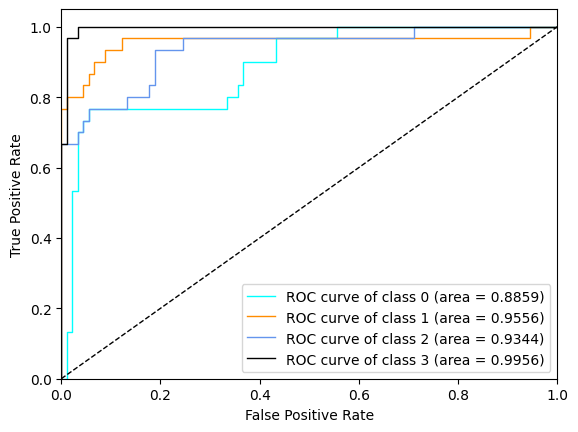

Report /n               precision    recall  f1-score   support

           0       0.82      0.77      0.79        30
           1       0.89      0.83      0.86        30
           2       0.93      0.87      0.90        30
           3       0.83      1.00      0.91        30

    accuracy                           0.87       120
   macro avg       0.87      0.87      0.87       120
weighted avg       0.87      0.87      0.87       120

Report cohen_kappa_score /n 0.8222222222222222
Report matthews_corrcoef /n 0.824055495896642


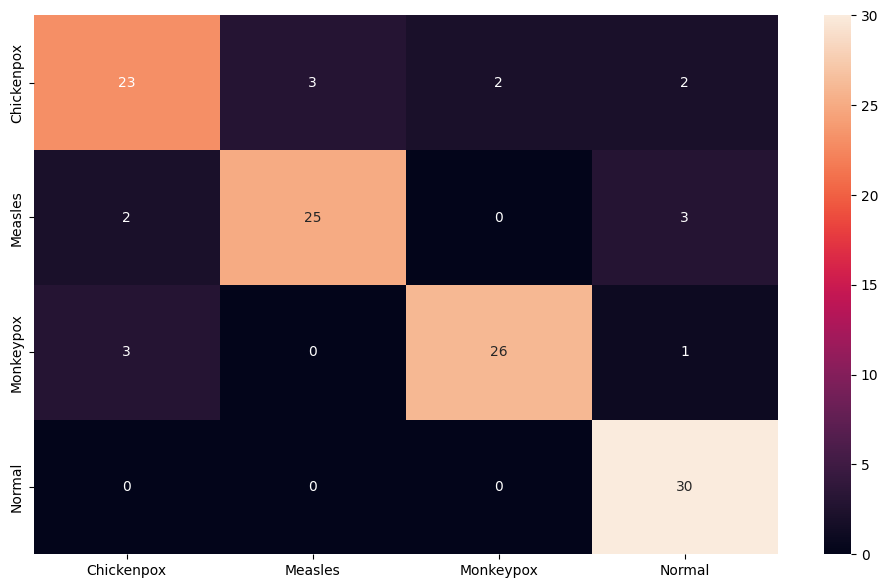

<Figure size 640x480 with 0 Axes>

In [33]:
valid_epoch(_model,_dataloaders["test"])

In [ ]:

from google.colab import runtime
runtime.unassign()